In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
keras = tf.keras

In [8]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def sessional_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * sessional_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

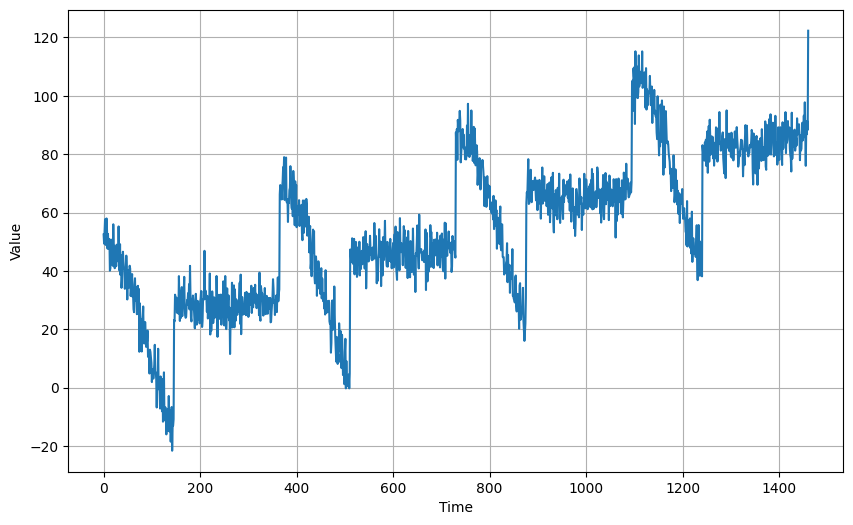

In [9]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time, 0.1)

amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

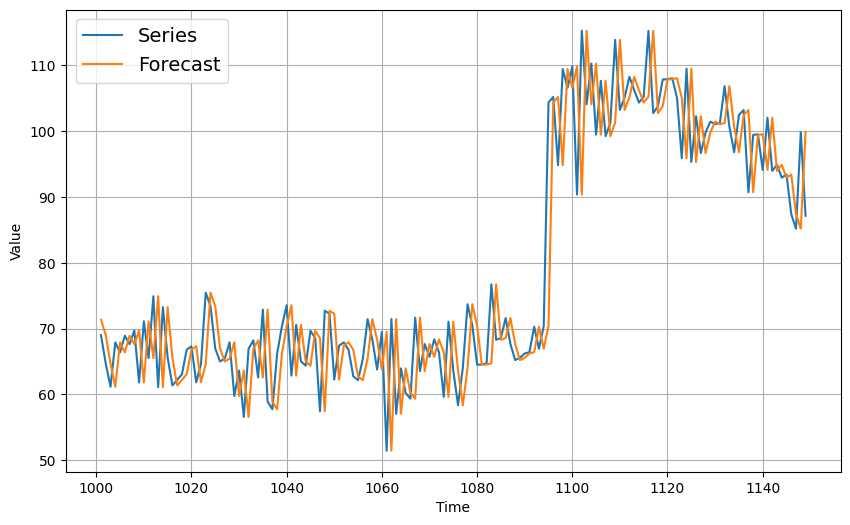

In [10]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series", start=1, end=150)
plot_series(time_valid, naive_forecast, label="Forecast", start=1, end=150)
plt.show()

In [11]:
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

5.9379085153216735

### Moving Average

In [12]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  # print("The size of series is {}".format(len(series)))
  for time in range(len(series) - window_size):
    forecast.append(series[time: time + window_size].mean())
  return np.array(forecast)

In [13]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
#   print("The size of series is {}".format(len(series)))
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]

  print("mov: {}".format(mov[:10]))
  print("mov[window_size - 1:-1]: {}".format(mov[window_size -1:-1]))
  print("mov[window_size - 1:-1] / window_size: {}".format(mov[window_size - 1:-1] / window_size))
  return mov[window_size - 1:-1] / window_size

Length of series is 1461
mov: [ 52.48357077 101.83632283 155.15106155 212.86288348 261.79732882
 310.72857103 368.71146791 422.60859045 470.28251661 522.96622345]
mov[window_size - 1:-1]: [1443.47541047 1434.26688222 1440.16396171 ... 2583.81805116 2592.30696359
 2597.99545136]
mov[window_size - 1:-1] / window_size: [48.11584702 47.80889607 48.00546539 ... 86.12726837 86.41023212
 86.59984838]
Moving Average array length:  461


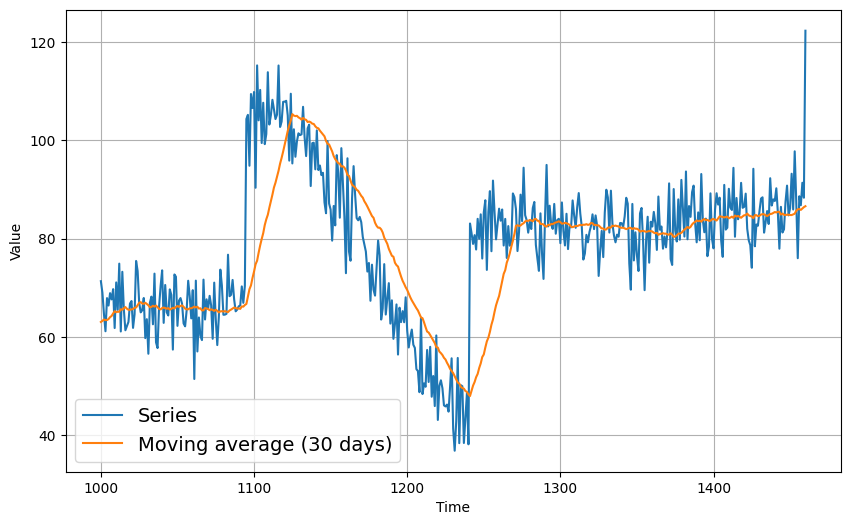

In [14]:
print("Length of series is {}".format(len(series)))

moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

print("Moving Average array length: ", len(moving_avg))

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [15]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

7.1424185706207854